In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import networkx as nx
import numpy as np

# 2.0. Co-author Graphs

Social network analysis is a popular method in the field of historical network research. By far the most accessible source of information about social networks in science are bibliographic metadata: we can examine relationships among published authors by modeling coauthorship as a graph. Of course, using bibliographic metadata alone has some drawbacks; for one, it renders many participants in scientific production invisible by focusing only on those who "merit" authorship -- laboratory technicians and other support staff, for example, aren't usually included as authors. Nevertheless, the sheer volume of available data makes bibliographic metadata an attractive place to start.

In this notebook, we'll use metadata collected from the Web of Science database to build a coauthor graph. For background, reading, and resources (including instructions on how to download WoS metadata in the correct format), please see [this page](https://diging.atlassian.net/wiki/display/DCH/Module+2%3A+Introduction+to+Networks).

## Loading data

I have provided some sample WoS metadata in the ``data`` directory. [Tethne](http://diging.github.io/tethne) (the Python package that we will use to parse these metadata) can parse multiple files at once; we just pass the path to the folder that contains our metadata files.

This set of metadata is from several years of the journal *Plant Physiology* -- so this is an artificially myopic sample of texts, but it works just fine for demonstration purposes.

In [3]:
from tethne.readers import wos

In [4]:
metadata = wos.read('../data/Baldwin/PlantPhysiology', 
                    streaming=True, index_fields=['date'], index_features=['authors'])

We can see how many records were parsed by taking the ``len()`` of the metadata.

In [5]:
len(metadata)

7849

## Create the graph

``Tethne``'s graph-building methods create ``NetworkX`` Graph objects.

In [6]:
from tethne import coauthors

In [7]:
graph = coauthors(metadata, edge_attrs=['date'])    # Just pass the metadata!

We can see how many authors (nodes) and edges are present by using the ``.order()`` and ``.size()`` methods, respectively.

In [8]:
graph.order(), graph.size(), nx.number_connected_components(graph)

(27139, 120180, 982)

YIKES! That's really big. Of course, for analytic purposes this shouldn't scare us. But it would be nice to make a visualization, and that's an awfully large graph to lay out in the time available during the class. So we'll be a bit more choosy. 

The ``coauthors()`` function accepts a few optional arguments. ``min_weight`` sets the minimum number of papers that two authors must publish together for an edge to be created between them.

In [9]:
graph = coauthors(metadata, min_weight=2., edge_attrs=['date'])

In [10]:
graph.order(), graph.size(), nx.number_connected_components(graph)

(5607, 9365, 1137)

That has a fairly significant impact on the overall size of the graph.

In [12]:
nx.write_graphml(graph, 'coauthors.graphml')

The resulting graph looks something like this:

![](images/coauthor_graph.png)

There is a large connected component in the upper left, and then a whole host of smaller connected components.

## Central authors

Depending on our research question, we may be interested in identifying the most "important" or "central" nodes in the coauthor graph. Networkx has a whole bunch of [algorithms](https://networkx.readthedocs.io/en/stable/reference/algorithms.html) that you can use to analyze your graph. Please take a look through the list; there are quite a few useful functions in there!

### Degree Centrality

Let's evaluate the degree-centrality of the nodes in our network.

In [13]:
degree_data = pd.DataFrame(columns=['Surname', 'Forename', 'Degree'])

i = 0
for (surname, forename), d in nx.degree(graph).items():
    degree_data.loc[i] = [surname, forename, d]
    i += 1

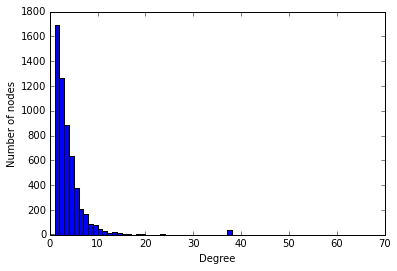

In [14]:
plt.hist(degree_data.Degree, bins=np.arange(0, 70, 1))
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.show()

In [15]:
# np.argsort() gives us row indices in ascending order of
#  value. [::-1] reverses the array, so that the values are
#  descending.
sort_indices = np.argsort(degree_data.Degree)[::-1]

# Here are the nodes with the highest degree.
for i in sort_indices[:5]:    # (just the top 5)
    print degree_data.loc[i]
    print '-' * 25

Surname         FERNIE
Forename    ALISDAIR R
Degree              68
Name: 2581, dtype: object
-------------------------
Surname       CANNON
Forename    STEVEN B
Degree            38
Name: 2524, dtype: object
-------------------------
Surname     DESHPANDE
Forename       SHWETA
Degree             37
Name: 4254, dtype: object
-------------------------
Surname        CANNON
Forename    ETHALINDA
Degree             37
Name: 1841, dtype: object
-------------------------
Surname     ASHFIELD
Forename         TOM
Degree            37
Name: 4776, dtype: object
-------------------------


### Closeness Centrality

Now let's try closeness centrality. Recall that:

$
C(x) = \frac{1}{\sum_y d(y, x)}
$

Where $d(y, x)$ is the distance between the nodes $y$ and $x$. $d(y, x)$ can be any function that calculates a distance value for two nodes. $y$ is all of the other nodes in the network (i.e. that are not $x$) reachable from $x$.

By default, NetworkX uses shortest path length as the distance parameter, and normalizes closeness based on the size of the connected component (i.e. the number of possible paths).

In [16]:
closeness_data = pd.DataFrame(columns=['Surname', 'Forename', 'Closeness'])

i = 0
for (surname, forename), d in nx.closeness_centrality(graph).items():
    closeness_data.loc[i] = [surname, forename, d]
    i += 1

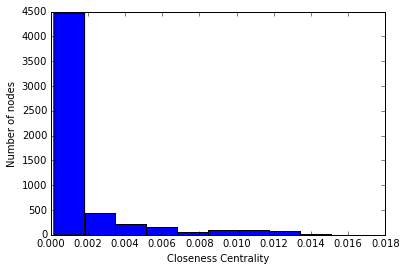

In [17]:
plt.hist(closeness_data.Closeness)
plt.ylabel('Number of nodes')
plt.xlabel('Closeness Centrality')
plt.show()

In [18]:
# And we can get the nodes with the highest closeness...
sort_indices = np.argsort(closeness_data.Closeness)[::-1]

# Here are the nodes with the highest degree.
for i in sort_indices[:5]:    # (just the top 5)
    print closeness_data.loc[i]
    print '-' * 25

Surname          FERNIE
Forename     ALISDAIR R
Closeness    0.01672587
Name: 2581, dtype: object
-------------------------
Surname            LUNN
Forename         JOHN E
Closeness    0.01522558
Name: 1207, dtype: object
-------------------------
Surname      URBANCZYKWOCHNIAK
Forename                   EWA
Closeness           0.01443648
Name: 4451, dtype: object
-------------------------
Surname      VAN DONGEN
Forename        JOOST T
Closeness    0.01431285
Name: 1410, dtype: object
-------------------------
Surname           BAUWE
Forename        HERMANN
Closeness    0.01420988
Name: 2, dtype: object
-------------------------


### Betweenness Centrality

Betweenness centrality is often interpreted as a measure of "power" in social networks -- the extent to which an individual controls information flow across the graph. Recall:

$
g(x) = \sum_{s \neq x \neq t} \frac{\sigma_{st}(x)}{\sigma_{st}}
$

Where $\sigma_{st}$ is the total number of shortest paths from node $s$ to  node $t$, and $\sigma_{st}(x)$ is the number of those paths that pass through node $x$.

Note that betweenness centrality is fairly computationally expensive, since we have to calculate all of the shortest paths for all of the nodes in the network. So this may take a minute or two.

In [19]:
betweenness_data = pd.DataFrame(columns=['Surname', 'Forename', 'Betweenness'])

i = 0
for (surname, forename), d in nx.betweenness_centrality(graph).items():
    betweenness_data.loc[i] = [surname, forename, d]
    i += 1

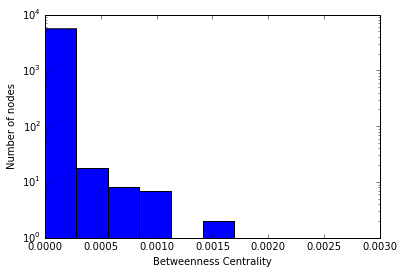

In [20]:
plt.hist(betweenness_data.Betweenness)
# It's a pretty lopsided distribution, so a log scale makes it 
#  easier to see.
plt.yscale('log')
plt.ylabel('Number of nodes')
plt.xlabel('Betweenness Centrality')
plt.show()

## Change over time

We can use Tethne to look at how graphs evolve. To do this, we use the ``slice()`` method. ``slice()`` is an **iterator**, which means that you can iterate over it (e.g. use it in a ``for``-loop). It yields subsets of the metadata, and we can use those build a graph for each time period.

By default, it returns a subset for each year.

In [21]:
graphs = []
years = []
for year, subset in metadata.slice(feature_name='authors'):
    graph = coauthors(subset)
    graphs.append(graph)
    years.append(year)
    print '\r', year,

2013


In [25]:
for year, graph in zip(years, graphs):
    print year, graph.order(), graph.size(), nx.number_connected_components(graph)

1999 1641 3674 327
2000 1757 4262 312
2001 2155 5513 364
2002 2201 5717 363
2003 2627 8611 359
2004 2687 9440 348
2005 2639 9365 310
2006 2350 7365 357
2007 2633 8799 337
2008 2749 10045 345
2009 2918 11020 336
2010 2912 11324 327
2011 3154 12549 329
2012 2892 11166 319
2013 2408 9953 268


In [26]:
nx.write_graphml(graphs[0], 'coauthors_1999.graphml')

The resulting graph is pretty sparse.

![](images/coauthor_graph_subset_0.png)

Sometimes it's helpful to use a sliding time-window: select subsets of several years, that overlap. This "smooths" things out. We'll try 3 years, since that's a pretty typical funding cycle.

In [27]:
graphs = []
years = []
for year, subset in metadata.slice(window_size=3, feature_name='authors'):
    graph = coauthors(subset)
    graphs.append(graph)
    years.append(year)
    print '\r', year,

2011


In [28]:
for year, graph in zip(years, graphs):
    print year, graph.order(), graph.size(), nx.number_connected_components(graph)

1999 4752 12848 558
2000 5206 14856 544
2001 5890 18999 507
2002 6416 22940 507
2003 6752 26548 455
2004 6903 25629 619
2005 7215 25132 783
2006 7033 25595 671
2007 7286 29036 553
2008 7514 31498 540
2009 7852 33935 506
2010 7829 34103 474
2011 7455 32665 464


In [29]:
nx.write_graphml(graphs[0], 'coauthors_1999-2001.graphml')

This looks a bit better:

![](images/coauthor_subset_threeyear.png)

## Following a specific node.

In [141]:
focal_author = ('FERNIE', 'ALISDAIR R')
fernie_data = pd.DataFrame(columns=['Year', 'Degree'])
i = 0
for year, graph in zip(years, graphs):
    degree = nx.degree(graph)
    # If the focal author is not in the graph for this time-period, then
    #  we will assign a closeness of 0.0.
    focal_degree = degree.get(focal_author, 0.0)
    fernie_data.loc[i] = [year, focal_degree]
    i += 1

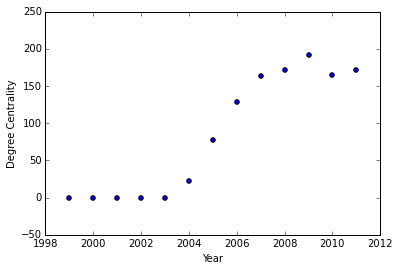

In [143]:
plt.scatter(fernie_data.Year, fernie_data.Degree)
plt.ylabel('Degree Centrality')
plt.xlabel('Year')

In [147]:
fernie_closeness = pd.DataFrame(columns=['Year', 'Closeness'])
i = 0
for year, subset in metadata.slice(window_size=3):
    graph = coauthors(subset, min_weight=2.)
    
    if focal_author in graph.nodes():
        focal_closeness = nx.algorithms.closeness_centrality(graph, u=focal_author)
    else:
        focal_closeness = 0.0

    fernie_closeness.loc[i] = [year, focal_closeness]  
    print '\r', year,
    
    i += 1

2011


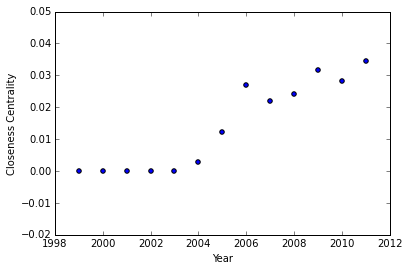

In [150]:
plt.scatter(fernie_closeness.Year, fernie_closeness.Closeness)
plt.ylabel('Closeness Centrality')
plt.xlabel('Year')
plt.show()

## International collaboration

We can use the information in the ``authorAddress`` attribute of each record to look at collaboration between scientists in different countries.

Note that the address is a bit "messy" -- it was written for human use, not for computers.

In [11]:
metadata[5].authorAddress

u'[Berr, Alexandre; McCallum, Emily J.; Alioua, Abdelmalek; Heintz, Dimitri; Heitz, Thierry; Shen, Wen-Hui] Univ Strasbourg, CNRS, Inst Biol Mol Plantes, F-67084 Strasbourg, France.'

In [15]:
metadata[205].authorAddress

[u'Arena Pharmaceut, San Diego, CA 92121 USA.',
 u'Univ Calif San Diego, Div Biol Sci, La Jolla, CA 92093 USA.']

In [42]:
len(metadata)

7849

So we define a procedure to extract the country from each address. Note that the country seems to come at the end, so...
* We split on commas and take the last element;
* We have to strip the '.' at the end;
* Note that USA addresses have state zip and country in the last position;

In [16]:
def extract_country(address):
    country = address.split(',')[-1].strip().replace('.', '')
    if country.endswith('USA'):
        return u'USA'
    return country

In [18]:
print metadata[205].authorAddress[0]
print extract_country(metadata[205].authorAddress[0])

Arena Pharmaceut, San Diego, CA 92121 USA.
USA


Let's make a graph by hand.

In [19]:
from collections import Counter
from itertools import combinations

In [22]:
node_counts = Counter()
edge_counts = Counter()

for paper in metadata:
    if not hasattr(paper, 'authorAddress'):
        continue
        
    addresses = getattr(paper, 'authorAddress', [])
    if not type(addresses) is list:
        addresses = [addresses]
    
    countries = [extract_country(address) for address in addresses]
    # Combinations is pretty cool. It will give us all of the
    #  possible combinations of countries in this paper.
    for u, v in combinations(countries, 2):
        edge_key = tuple(sorted([u, v]))
        edge_counts[edge_key] += 1.
        
    for u in set(countries):
        node_counts[u] += 1.

In [23]:
international = nx.Graph()
for u, count in node_counts.items():
    international.add_node(u, weight=count)
    
for (u, v), count in edge_counts.items():
    if count > 1. and u != v:
        international.add_edge(u, v, weight=count)

In [24]:
nx.adjacency_matrix(international).todense()

matrix([[ 0.,  6.,  0., ...,  0.,  2.,  6.],
        [ 6.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  2.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  2., ...,  0.,  0.,  0.],
        [ 6.,  0.,  0., ...,  0.,  0.,  0.]])

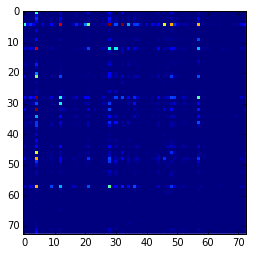

In [25]:
plt.imshow(nx.adjacency_matrix(international).todense(), 
           interpolation='none')

In [27]:
print international.order(), \
      international.size(), \
       nx.number_connected_components(international)

73 419 6


In [28]:
nx.write_graphml(international, 'international.graphml')

![](images/international.png)

In [41]:
def international_collaboration(subset):
    node_counts = Counter()
    edge_counts = Counter()

    for paper in subset:
        if not hasattr(paper, 'authorAddress'):
            continue

        addresses = getattr(paper, 'authorAddress', [])
        if not type(addresses) is list:
            addresses = [addresses]

        countries = [extract_country(address) for address in addresses]
        # Combinations is pretty cool. It will give us all of the
        #  possible combinations of countries in this paper.
        for u, v in combinations(countries, 2):
            edge_key = tuple(sorted([u, v]))
            edge_counts[edge_key] += 1.

        for u in set(countries):
            node_counts[u] += 1.
            
    graph = nx.Graph()
    for u, count in node_counts.items():
        graph.add_node(u, weight=count)

    for (u, v), count in edge_counts.items():
        if count > 1.:
            graph.add_edge(u, v, weight=count)
    
    return graph

In [42]:
years = []
graphs = []
for year, subset in metadata.slice(window_size=3):
    graph = international_collaboration(subset)
    graphs.append(graph)
    years.append(year)
    print year, graph.order(), graph.size(),

2011 57 285


## With whom does the Netherlands collaborate?

In [43]:
netherlands_data = pd.DataFrame(columns=['Year', 'Neighbor', 'Collaboration'])

In [44]:
i = 0
for year, graph in zip(years, graphs):
    if 'Netherlands' not in graph.nodes():
        continue
        
    counts = Counter()
    for neighbor in graph.neighbors('Netherlands'):
        counts[neighbor] += graph['Netherlands'][neighbor]['weight']
    
    N_all = sum(counts.values())
    for neighbor, count in counts.items():
        netherlands_data.loc[i] = [year, neighbor, count/N_all]
        i += 1
        
    print '\r', year,

2011


In [45]:
grouped = netherlands_data.groupby('Neighbor')

In [46]:
collaboration_means = grouped.Collaboration.mean()
collaboration_std = grouped.Collaboration.std()

In [47]:
grouped.Collaboration.describe()

Neighbor          
Argentina    count     2.000000
             mean      0.011870
             std       0.000531
             min       0.011494
             25%       0.011682
             50%       0.011870
             75%       0.012057
             max       0.012245
Australia    count    10.000000
             mean      0.034122
             std       0.033650
             min       0.009217
             25%       0.015401
             50%       0.016228
             75%       0.043264
             max       0.095745
Belgium      count    13.000000
             mean      0.081166
             std       0.038387
             min       0.016260
             25%       0.050000
             50%       0.085714
             75%       0.107280
             max       0.145833
Brazil       count     3.000000
             mean      0.010831
             std       0.005060
             min       0.007663
             25%       0.007913
             50%       0.008163
                     

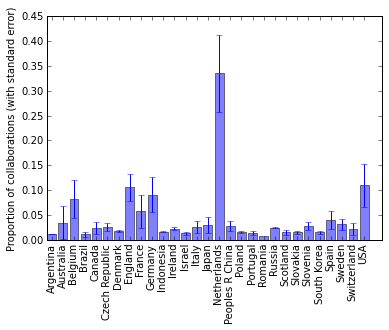

In [48]:
positions = np.arange(len(collaboration_means))
plt.bar(positions, collaboration_means.values, yerr=collaboration_std, alpha=0.5)
plt.xticks(positions + 0.4, collaboration_means.keys(), rotation=90)
plt.ylabel('Proportion of collaborations (with standard error)')
plt.show()

## Has collaboration between Netherlands and specific neighbors changed over time?

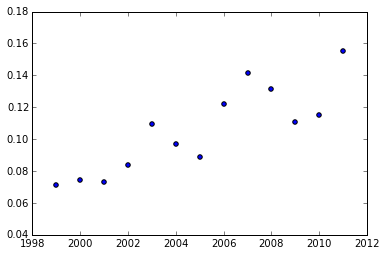

In [49]:
collaboration_england = netherlands_data[netherlands_data.Neighbor == 'England']
plt.scatter(collaboration_england.Year, collaboration_england.Collaboration)
plt.show()

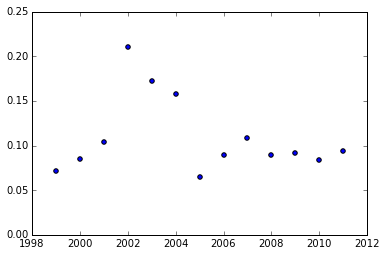

In [50]:
collaboration_usa = netherlands_data[netherlands_data.Neighbor == 'USA']
plt.scatter(collaboration_usa.Year, collaboration_usa.Collaboration)
plt.show()

### How about with itself? I.e. is Netherlands becoming more or less externally collaborative over time?

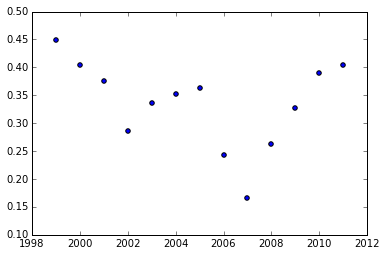

In [51]:
collaboration_self = netherlands_data[netherlands_data.Neighbor == 'Netherlands']
plt.scatter(collaboration_self.Year, collaboration_self.Collaboration)
plt.show()

## How central is the Netherlands in terms of international collaboration?

In [52]:
netherlands_centrality = pd.DataFrame(columns=['Year', 'Centrality'])
i = 0
for year, graph in zip(years, graphs):
    if 'Netherlands' not in graph.nodes():
        continue
    centrality = nx.closeness_centrality(graph, u='Netherlands')
    netherlands_centrality.loc[i] = [year, centrality]
    i += 1

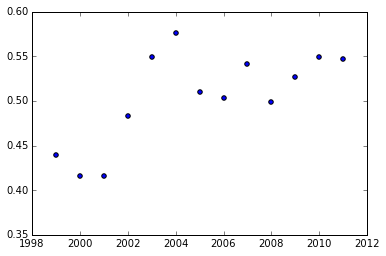

In [53]:
plt.scatter(netherlands_centrality.Year, netherlands_centrality.Centrality)

------- ---------- -----------

# Below: to be completed

### Connectivity over time

Ok, we have a graph for each time-period. Let's look at some whole-graph parameters. How about average clustering.

$$
C = \frac{1}{n} \sum_{v \in G} c_v
$$

and

$$
c_u = \frac{2 T}{deg(u)(deg(u) - 1)}
$$

where $T(u)$ is the number of triangles through node $u$, and $deg(u)$ is the degree of $u$.

In [ ]:
clustering_data = pd.DataFrame(columns=['Year', 'Clustering'])

i = 0
# zip() zips two lists together into a list of 2-tuples.
for year, graph in zip(years, graphs):
    clustering_data.loc[i] = [year, nx.algorithms.average_clustering(graph)]
    i += 1
    
plt.scatter(clustering_data.Year, clustering_data.Clustering)
plt.ylabel('Average Clustering Coefficient')
plt.xlabel('Year')
plt.show()

I wonder if that upward trend has anything to do with the overall number of authors or number of papers in each time period.

In [ ]:
authorship_data = pd.DataFrame(columns=['Year', 'AverageNumAuthors', 'NumPapers'])
i = 0
for year, subset in metadata.slice(window_size=3):
    avg_no_authors = np.mean([len(paper.authors) for paper in subset])
    authorship_data.loc[i] = [year, avg_no_authors, len(subset)]
    i += 1

In [33]:
plt.scatter(authorship_data.Year, authorship_data.AverageNumAuthors, c='green')
plt.legend(loc=4)
plt.ylabel('Average Number of Authors (green)')
ax = plt.gca()
ax2 = plt.twinx()

ax2.scatter(authorship_data.Year, authorship_data.NumPapers)
plt.ylabel('Number of Papers (blue)')

plt.xlabel('Year')
plt.legend(loc='best')
plt.show()

NameError: name 'authorship_data' is not defined

That's an interesting pattern -- the average number of authors in each period steadily increases, while the number of papers decreases. That certainly might explain the additional clustering! Let's combine these two values, so that we'll have 

$
\frac{N_{Authors}}{N_{Papers}} * \frac{1}{N_{Papers}} = \frac{N_{Authors}}{N_{Papers}^2}
$

And compare that to the average clustering coefficient.


In [ ]:
plt.scatter(authorship_data.AverageNumAuthors/authorship_data.NumPapers,
            clustering_data.Clustering)
xlim(0.002, 0.006)
plt.xlabel('$\\frac{N_{Authors}}{N_{Papers}^2}$', size=24)
plt.ylabel('Average Clustering Coefficient')
plt.show()

In [ ]:
from scipy.stats import linregress
authorship = authorship_data.AverageNumAuthors/authorship_data.NumPapers
Beta, Beta0, r, p, stderr = linregress(authorship, clustering_data.Clustering)

plt.scatter(authorship_data.AverageNumAuthors/authorship_data.NumPapers,
            clustering_data.Clustering)

X = np.arange(authorship.min(), authorship.max(), 0.0001)
plt.plot(X, Beta0 + Beta*X)
xlim(0.002, 0.006)
plt.xlabel('$\\frac{N_{Authors}}{N_{Papers}^2}$', size=24)
plt.ylabel('Average Clustering Coefficient')
plt.show()

Y_hat = Beta0 + Beta*authorship
residuals = clustering_data.Clustering - Y_hat
plt.scatter(clustering_data.Year, residuals)